# Banking Channel Usage Analysis, Customer Segmentation & Forecasting

## Channel Analysis in Banking
Banks operate multiple channels such as ATMs, online banking, mobile apps, and POS systems. 
Understanding how customers use these channels is critical for cost optimization, digital transformation, 
and customer experience improvement.

This project analyzes transaction-level banking data to:
- Understand channel usage patterns
- Segment customers based on channel behavior
- Forecast future channel demand

**This first part of the project focuses on understanding how customers interact with banking channels and how banks can optimize digital adoption**

## 1. Import Libraries

In this section, I import the Python libraries required for data analysis, visualization, 
customer segmentation, and time-series forecasting.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from prophet import Prophet

I will use Pandas and Numpy for data manipulation. Scikit-learn for segmentation, and Prophet for time-series forecasting.

## 2. Load the Dataset
I will be using two different datasets in this project, to avoid mix up I will subdivide the project into two parts. 

        1.Banking Channel Analysis
        2.Customer Segmentation and Churn Modelling

- ### Banking Channel Analysis
Here I will do the following: 

        > Channel exploration
        > Channel segmentation
        > Channel forecasting(selective)

In [2]:
transactions = pd.read_csv("Data/bank_transactions_data.csv")
transactions.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


The dataset contains transactional-level banking data, including transaction
amounts, channels used, customer demographics, and behavioral indicators.
Each row represents a single banking transaction.

## 3. Initial Data Understanding

In this section, we inspect the structure of the dataset to understand available columns, data types, and the overall shape of the data.

In [4]:
#Data Structure of transactions
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

Before I begin modelling, I have explored the datasets to understand available features and potential use cases 

Key columns used in this analysis include:

- **TransactionID:** Unique identifier for each transaction
- **AccountID:** Customer account identifier
- **TransactionAmount:** Monetary value of the transaction
- **TransactionDate:** Timestamp of the transaction
- **Channel:** Banking channel used (ATM, Online, Branch)
- **CustomerAge:** Age of the customer
- **TransactionDuration:** Time taken to complete transaction

# Key details about transactions data frame:
- **Total Entries:** 2512, ranging from index 0 to 2511
- **Total Columns:** 16 columns
- **-Non-Null Counts:** their is no missing values in this dataframe, all column have 2512 entries
- **Data Types**: I am working with threee data types

        - 2columns(**TransactionAmount, AccountBalance**): float64 types
        - 3columns(**CustomerAge,TransactionDuration,LoginAttempts**): int64 types
        -11columns: (**the rest are objects of type string**)

**I validated data quality by checking data types and missing values before feature engineering.**

## 6. Date Formatting

Transaction timestamps are converted to datetime format to support trend analysis and forecasting.

In [9]:
transactions["TransactionDate"] = pd.to_datetime(transactions["TransactionDate"])

## 7. Banking Channel Distribution

We examine how transactions are distributed across different banking channels.


In [8]:
channel_counts = (
    transactions.groupby("Channel")
    .size()
    .reset_index(name="transaction_count")
)

channel_counts

,Channel,transaction_count
0,ATM,833
1,Branch,868
2,Online,811


# Banking Channel Distribution Explanation
This output shows the total number of transactions per banking channel.
It provides a high-level view of how customers prefer to interact with the bank.

# Channel Usage Visualisation

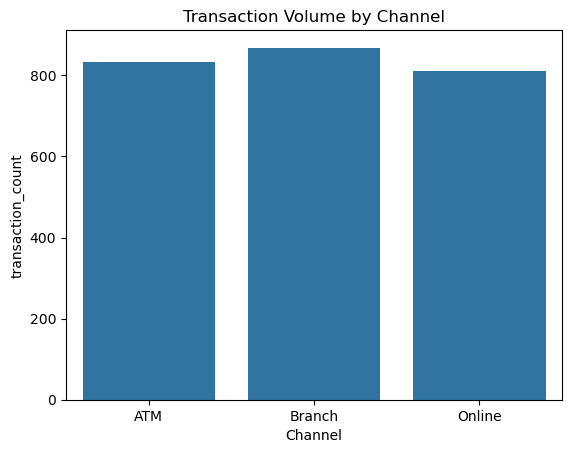

In [9]:
sns.barplot(
    data=channel_counts,
    x="Channel",
    y="transaction_count"
)
plt.title("Transaction Volume by Channel")
plt.show()

# Create Channel-Level Behavioral Metrics

In [11]:
channel_metrics = transactions.groupby("Channel").agg(
    total_transactions=("TransactionID", "count"),
    total_amount=("TransactionAmount", "sum"),
    avg_amount=("TransactionAmount", "mean"),
    avg_duration=("TransactionDuration", "mean")
).reset_index()

channel_metrics

,Channel,total_transactions,total_amount,avg_amount,avg_duration
0,ATM,833,256331.43,307.720804,122.091236
1,Branch,868,250183.00,288.229263,116.675115
2,Online,811,241041.14,297.214723,120.305795


# Channel Metrics Interpretation
The metrics highlight behavioral differences across channels.
For example, some channels may handle fewer but higher-value transactions,
while others support frequent low-value interactions.


# Channel Segmentation (K-Means)

In [13]:
segmentation_transactions = channel_metrics.drop(columns=["Channel"])
segmentation_transactions

,total_transactions,total_amount,avg_amount,avg_duration
0,833,256331.43,307.720804,122.091236
1,868,250183.00,288.229263,116.675115
2,811,241041.14,297.214723,120.305795


# Feature Scaling

In [15]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(segmentation_transactions)

# Apply K-Means

In [16]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

channel_metrics["Cluster"] = clusters
channel_metrics

c:\Users\Administrator\anaconda3\envs\ds-env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,Channel,total_transactions,total_amount,avg_amount,avg_duration,Cluster
0,ATM,833,256331.43,307.720804,122.091236,2
1,Branch,868,250183.00,288.229263,116.675115,0
2,Online,811,241041.14,297.214723,120.305795,1


# Segmentation Interpretation
Channels are grouped based on transaction intensity and value.
Each cluster represents a distinct operational role within the banking ecosystem.

# Forecasting Transactions using Prophet

In [17]:
# Select online channel
online_transactions = transactions[transactions["Channel"]== "Online"].copy()

In [19]:
# Create Time-Series Dataset
online_ts = (
    online_transactions.groupby("TransactionDate")
    .size()
    .reset_index(name="y")
    .rename(columns={"TransactionDate": "ds"})
)

online_ts.head()

,ds,y
0,2023-01-02 16:01:26,1
1,2023-01-02 16:07:17,1
2,2023-01-02 16:27:18,1
3,2023-01-02 16:30:09,1
4,2023-01-02 16:47:11,1


# Forecast Explanation
The data is reshaped into Prophet’s required format:
- **ds:** Date column
- **y:** Transaction count per day

In [20]:
# Train Prophet Model
model = Prophet()
model.fit(online_ts)

In [21]:
#Generate Forecast
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Forecast Interpretation
The forecast estimates future transaction volumes based on historical patterns,
capturing trend and seasonality effects.